# A Python Guide to Spotify's API

I recently accessed my first API and wanted to share my process to help others. This notebook is intended to be a **quick beginners guide** to extracting data from Spotify's API using Python. It assumes a basic understanding of Python, a Spotify Account and Developer Account, and nothing of APIs or authentication. Most technical details are skipped to get you exploring sooner. Nonetheless, **questions are welcomed**.

If your like me, you registered your app on Spotify, recieved your *client id* and *client secret*, and took a look into the provided authorization guide but to no avail. *Sigh* right?. No worries, I'll show you how to **gain authentication** and **navigate the api** so that you can explore your own interest later.

We'll be using the ***client credentials flow*** to retreive the *audio features* of all listed albums from some of my favorite rappers: Big Sean, Isaiah Rashad, J. Cole, Kendrick Lamar, and Schoolboy Q. We'll then place the data into data frames for exploratory data analysis. To achieve this we'll need to complete several intermediate steps outlined here, accompanying documentation just for reference:

1. [Client Credentials Flow setup](https://developer.spotify.com/documentation/general/guides/authorization-guide/#client-credentials-flow) (scroll down ~80% of the doc page)
2. [Search for artist and retrieve artist ids](https://developer.spotify.com/documentation/web-api/reference/search/search/)
3. [Retrieve an Artist's albums and their ids](https://developer.spotify.com/documentation/web-api/reference/artists/get-artists-albums/)
4. [Retrieve an Album's tracks ids](https://developer.spotify.com/documentation/web-api/reference/albums/get-albums-tracks/)
5. [Retrieve audio features for each track](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/)
6. Merge all DataFrames

Each id is a Spotify *unique identifier* for the specific item. Also, along the way we'll create sub-DataFrames that will hold key information for our final DataFrame.

## 1. Client Credentials Flow setup

The Client Credentials Flow allows us to access non-user related information from Spotify's API. Since we'll only be working with Artist, their ablums, and their tracks this is the perfect flow. To setup we'll need our client id and client secret and 3 Python libraries installed: [oauthlib](https://oauthlib.readthedocs.io/en/v3.0.1/), [requests](http://www.python-requests.org/en/latest/), and [authlib](https://docs.authlib.org/en/latest/). 

The first code input shows me reading in my credentials from an external file only because im sharing online. If you don't plan on sharing online then you can just assign your id and secret to each variable. 

In [1]:
#reading in credentials
import csv

client_id = ''
client_secret = ''
with open('credentials.txt',newline='\n') as f:
    reader = csv.reader(f)
    data = list(reader)
    client_id = data[0][0]
    client_secret = data[1][0]

This second code input is about setting up a secure line of communication between your computer and Spotify's API. Here we are looking to gain authentication from the API in the form of an *access token*. The *access token* allows us to make calls to the API later without having to repeat authentication each time.  

In [2]:
#retreving access token
from oauthlib.oauth2 import BackendApplicationClient
from requests.auth import HTTPBasicAuth
from authlib.client import OAuth2Session

auth = HTTPBasicAuth(client_id, client_secret)
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)
token = oauth.fetch_token(url='https://accounts.spotify.com/api/token', auth=auth)

#print(token)
# if sucessful you should see a json object with your access token, token type, expiration duration, scope, 
# and expiration time

Just like that the hardest part is done! Here we save our access_token and headers that will need to be passed with each call. The header is another step of security required by Spotify.

In [3]:
access_token = token['access_token']
headers = {'Authorization': 'Bearer ' + access_token}

## 2. Search for artist and retrieve artist ids

We begin with retrieving artist ids first because artist names are typically unique as opposed to album names. To retrieve artist ids we will need to use the *search endpoint* and provide the required query parameters of a **query term**, artist name, and the **query term type**, artist. This call will return an [artist object](https://developer.spotify.com/documentation/web-api/reference/object-model/#artist-object-simplified) that contains the artist id. The accessing of a json object, lines 15-16, is very similar to the indexing of a Python dictionary.  We'll pair the artist name and id in a python dictionary.

In [4]:
import requests
import json

search = ['big sean', 'isaiah rashad','kendrick lamar','j. cole', 'schoolboy q']

artist_ids = {}
for artist in search:
    params = {'q': artist, 'type': 'artist'}
    response = requests.get('https://api.spotify.com/v1/search', headers=headers, params=params)
    
    status = response.status_code
    if status == 200:
        json = response.json()
        # for consistency, let's update our spelling of artist names with the api's
        artist_name = json['artists']['items'][0]['name'].lower()
        artist_id = json['artists']['items'][0]['id']
        artist_ids[artist_id] = artist_name
    else:
        print('Search failed for', artist)

In [5]:
print(artist_ids)

{'0c173mlxpT3dSFRgMO8XPh': 'big sean', '6aaMZ3fcfLv4tEbmY7bjRM': 'isaiah rashad', '2YZyLoL8N0Wb9xBt1NhZWg': 'kendrick lamar', '6l3HvQ5sa6mXTsMTB19rO5': 'j. cole', '5IcR3N7QB1j6KBL8eImZ8m': 'schoolboy q'}


## 3. Retrieve an Artist's albums and their ids

Retrieving the albums of each artist can be done two ways:

1. Utilizing the method we just used previously but this time specifying the album name and type: album. Although this would require us to filter through the results to ensure that we have the correct album from the correct artist. This would be a little bit more time consuming since several artist can reuse an album name.
    
2. Our other option is to utilize the **artist id** we obtained and use that to identify albums specific to that artist only.
    
We'll be using the second method, which utilizes the [Artist's albums endpoint](https://developer.spotify.com/documentation/web-api/reference/artists/get-artists-albums/), as it has one less check than the first. Unlike the previous endpoint, this one requires a **path parameter** which in this case is the artist id we retrieved and will limit our search of albums to the specified artist. Similarly, this endpoint doesn't require any parameters instead we can provide optional parameters that will help filter our results. We provide in **include_groups** to filter our search to entire albums by the artist, and **country** to limit albums released only in the US. 

On return this endpoint sends back a list of [album objects (simplified)](https://developer.spotify.com/documentation/web-api/reference/object-model/#album-object-simplified) which we can access to retrieve the album id, album name, and artist name. We place this information into a python dictionary assigning the album id as the key and the album name and artist in a tuple as the value. 

In [6]:
album_ids = {}

for artist_id in artist_ids:
    params = {'include_groups': 'album', 'country': 'US'}
    response = requests.get('https://api.spotify.com/v1/artists/{}/albums'.format(artist_id),
                            headers=headers, params=params
                           )
    albums_list = []
    status = response.status_code
    if status == 200:
        json = response.json()
        for album_object in json['items']:
            # the API returns separate album objects for different licensing providers,
            # clean version, and explicit version of the album, we just want one.
            if album_object['name'] not in albums_list:
                albums_list.append(album_object['name'])
                # for consistency, update our spelling of album names with the api's
                album_ids[album_object['id']] = (album_object['name'],album_object['artists'][0]['name'])
    else:
        print('Search failed for artist id:', artist_id)

In [7]:
print(album_ids,'\n->size: {}'.format(len(album_ids)))

{'0llyIxX3nDC3hobbGibVZl': ('Double Or Nothing (& Metro Boomin)', 'Big Sean'), '0XAIjjN5qxViVS0Y5fYkar': ('I Decided.', 'Big Sean'), '4Nlbt2EuXedr6UqaeXEI4c': ('Dark Sky Paradise (Deluxe)', 'Big Sean'), '1j2x7FJXTgUT0X5hZ8TDXE': ('Dark Sky Paradise', 'Big Sean'), '5RlT8X7XGGLKUhoimrDl54': ('Hall Of Fame (Deluxe)', 'Big Sean'), '5k2URimhkeCTt0m7xm5mjz': ('Hall Of Fame', 'Big Sean'), '19DGkH750PrQMMnKqBAxfY': ('Finally Famous (Deluxe)', 'Big Sean'), '2fRLnox9PQ9nos2YYdcYwE': ('Finally Famous', 'Big Sean'), '6jjX8mGrsWtrpYpFhGMrg1': ("The Sun's Tirade", 'Isaiah Rashad'), '6JF49ixyHmOgS0Rsda2k42': ('Cilvia Demo', 'Isaiah Rashad'), '3pLdWdkj83EYfDN6H2N8MR': ('Black Panther The Album Music From And Inspired By', 'Kendrick Lamar'), '4alcGHjstaALJHHiljfy3H': ('DAMN. COLLECTORS EDITION.', 'Kendrick Lamar'), '4eLPsYPBmXABThSJ821sqY': ('DAMN.', 'Kendrick Lamar'), '0kL3TYRsSXnu0iJvFO3rud': ('untitled unmastered.', 'Kendrick Lamar'), '7ycBtnsMtyVbbwTfJwRjSP': ('To Pimp A Butterfly', 'Kendrick Lamar

As you may observed we didn't prevent all versions of albums as we also picked up deluxe, live, and collectors versions of albums. Typically deluxe versions hold bonus tracks, the more tracks the better, so we'll keep those and remove the other duplicates from our dictionary here.

In [8]:
album_deletions = ['Dark Sky Paradise', 'Hall Of Fame', 'Finally Famous', 
                   'DAMN. COLLECTORS EDITION.', 'good kid, m.A.A.d city', 
                   'Forest Hills Drive: Live from Fayetteville, NC', 'Oxymoron'
                  ]
key_deletions = []
# to ensure we don't make more checks then required
count = 0
for key,value in album_ids.items():
    if value[0] in album_deletions:
        key_deletions.append(key)
        count += 1
    if count == len(album_deletions):
        break

for key in key_deletions:
    del album_ids[key]

In [9]:
print(album_ids.values(),'\n->album_ids size: {}'.format(len(album_ids)))

dict_values([('Double Or Nothing (& Metro Boomin)', 'Big Sean'), ('I Decided.', 'Big Sean'), ('Dark Sky Paradise (Deluxe)', 'Big Sean'), ('Hall Of Fame (Deluxe)', 'Big Sean'), ('Finally Famous (Deluxe)', 'Big Sean'), ("The Sun's Tirade", 'Isaiah Rashad'), ('Cilvia Demo', 'Isaiah Rashad'), ('Black Panther The Album Music From And Inspired By', 'Kendrick Lamar'), ('DAMN.', 'Kendrick Lamar'), ('untitled unmastered.', 'Kendrick Lamar'), ('To Pimp A Butterfly', 'Kendrick Lamar'), ('good kid, m.A.A.d city (Deluxe)', 'Kendrick Lamar'), ('Section.80', 'Kendrick Lamar'), ('Overly Dedicated', 'Kendrick Lamar'), ('KOD', 'J. Cole'), ('4 Your Eyez Only', 'J. Cole'), ('2014 Forest Hills Drive', 'J. Cole'), ('Born Sinner', 'J. Cole'), ('Cole World: The Sideline Story', 'J. Cole'), ('Blank Face LP', 'ScHoolboy Q'), ('Oxymoron (Deluxe)', 'ScHoolboy Q'), ('Habits & Contradictions', 'ScHoolboy Q'), ('Setbacks', 'ScHoolboy Q')]) 
->album_ids size: 23


## Album DataFrame

In [10]:
import pandas as pd

columns= ['album','artist']
album_df = pd.DataFrame.from_dict(album_ids,orient='index')
album_df.columns = columns
print(album_df.head(10))

                                                                    album  \
0llyIxX3nDC3hobbGibVZl                 Double Or Nothing (& Metro Boomin)   
0XAIjjN5qxViVS0Y5fYkar                                         I Decided.   
4Nlbt2EuXedr6UqaeXEI4c                         Dark Sky Paradise (Deluxe)   
5RlT8X7XGGLKUhoimrDl54                              Hall Of Fame (Deluxe)   
19DGkH750PrQMMnKqBAxfY                            Finally Famous (Deluxe)   
6jjX8mGrsWtrpYpFhGMrg1                                   The Sun's Tirade   
6JF49ixyHmOgS0Rsda2k42                                        Cilvia Demo   
3pLdWdkj83EYfDN6H2N8MR  Black Panther The Album Music From And Inspire...   
4eLPsYPBmXABThSJ821sqY                                              DAMN.   
0kL3TYRsSXnu0iJvFO3rud                               untitled unmastered.   

                                artist  
0llyIxX3nDC3hobbGibVZl        Big Sean  
0XAIjjN5qxViVS0Y5fYkar        Big Sean  
4Nlbt2EuXedr6UqaeXEI4c       

## 4. Retrieve an Album's tracks ids

Having obtained album ids we can now move forward to obtain track ids for each track on the album. Luckily Spotify provides an endpoint to retrieve all the [tracks of an album](https://developer.spotify.com/documentation/web-api/reference/albums/get-albums-tracks/) instead of one by one. Similar to the previous step, we need to provide a **path parameter**, the album id. No required parameters again but the optional parameter we'll provide, **market**: US, limits our search to tracks released in the US album release. For albums with more than 20 tracks, you'll want to include the **limit** optional parameter to grab a max of 50. To keep things organized we'll collect all the track names with their track id in a tuple, all track tuples in a list, and the list in a dictionary with the respective album name.

In [11]:
tracks = {}
for album_id in album_ids:
    params = {'market': 'US'}
    response = requests.get('https://api.spotify.com/v1/albums/{}/tracks'.format(album_id), 
                            headers=headers, params=params
                           )
    status = response.status_code
    if status == 200:
        json = response.json()
        for track_object in json['items']:
            tracks[track_object['id']] = (track_object['name'],album_id)
    else:
        print(response.content)

In [12]:
# showing a sample of one track
print(tracks[list(tracks)[0]])

('Go Legend (& Metro Boomin)', '0llyIxX3nDC3hobbGibVZl')


## Track DataFrame

In [13]:
columns = ['track','album_id']
track_df = pd.DataFrame.from_dict(tracks,orient='index')
track_df.columns = columns
print(track_df.head())

                                                     track  \
3wAI7MIQtTgwcRmwchPZBc          Go Legend (& Metro Boomin)   
42XnD59SFcomCJu55EPhqJ        Big Bidness (& Metro Boomin)   
7dHui7yOhsoj7HdWSuJTW7  Who's Stopping Me (& Metro Boomin)   
7DuvVy7JfFgXwWlVzyyPys    Pull Up N Wreck (& Metro Boomin)   
0fWBFDRTIuk8ZgNdZqhCer            So Good (& Metro Boomin)   

                                      album_id  
3wAI7MIQtTgwcRmwchPZBc  0llyIxX3nDC3hobbGibVZl  
42XnD59SFcomCJu55EPhqJ  0llyIxX3nDC3hobbGibVZl  
7dHui7yOhsoj7HdWSuJTW7  0llyIxX3nDC3hobbGibVZl  
7DuvVy7JfFgXwWlVzyyPys  0llyIxX3nDC3hobbGibVZl  
0fWBFDRTIuk8ZgNdZqhCer  0llyIxX3nDC3hobbGibVZl  


## 5. Retreive audio features for each track

With track ids in hand, our final extraction is the audio features for each track. We could extract audio for each track individually but Spotify allows for us to pass multiple track ids, **max of 100**, and recieve audio features for each in one response (more on this in a bit). To do so, a single string is to be passed with each id separated by a comma. Of course we'll be taking advantage of this. On return we recieve a list of dictionaries that contains the audio features with other information about the track. For this extraction we'll store all track audio features together in a dictionary.

Since we are looking to recieve audio features for 333 tracks we'll have to split our request into 4 parts. We do so by creating a function *partition_dict* that as the name suggests, partitions the dictionary into increments allowed by the API.

In [14]:
import math
def partition_dict(my_dict,increments):
    my_list = list(my_dict.keys())
    size = len(my_list)
    parts = math.ceil(size/increments)    
    
    partitions = []
    for i in range(0,parts):
        partitions.append(my_list[i*increments:(100+(i*increments))])

    return partitions

In [15]:
track_features = {}
for part in partition_dict(tracks,100):
    ids = ''
    for track_id in part:
        #placing all ids into a single string
        ids += track_id + ','
    #remove last comma
    params = {'ids': ids[:-1]}
    response = requests.get('https://api.spotify.com/v1/audio-features',
                           headers=headers, params=params
                           )
    status = response.status_code
    if status == 200:
        json = response.json()
        audio_features = json['audio_features']
        for track_object in audio_features:
            track_features[track_object['id']] = track_object
    else:
        print(response.content)

In [16]:
#333 audio features?
print(len(track_features))

333


## Audio Features DataFrame

In [17]:
audio_features_df = pd.DataFrame.from_dict(track_features,orient='index')
#removal of non-essential columns, remember the 'id' column is our index
audio_features_df = audio_features_df.drop(['analysis_url','track_href','uri','type','id'],axis=1)
audio_features_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
00ogmsZiK6dB0QVUDBeehZ,0.361,0.793,0,-2.008,1,0.0507,0.011100,0.000000,0.223,0.314,76.082,106463,4
01VGA34ATxwp0Xo1ldduo2,0.652,0.455,8,-8.673,1,0.1150,0.855000,0.000000,0.171,0.325,83.151,875307,4
01kYL8egWVVF09irxev3dh,0.759,0.782,11,-6.975,0,0.0741,0.000589,0.000000,0.350,0.507,131.040,352853,4
01wKeKPgYxdPYA8rfMveYc,0.682,0.717,1,-3.682,1,0.2460,0.385000,0.000000,0.152,0.507,90.147,426997,4
03S5vMBN07OOnPj1SCMsxV,0.468,0.912,1,-6.909,0,0.4480,0.087400,0.000015,0.128,0.438,139.505,334907,4


## 6. Merge all DataFrames

Our last step is to bring all the relevant data into a single dataframe. This will include not only the audio features we set out to acquire but also the track title, album title, and artist name. 

We'll work backwards from our Audio Features dataframe and incrementally merge in relevant information first with our Track Dataframe, then with our Album DataFrame. Throughout we'll keep the *track id* as the index of each row.

In [18]:
df = audio_features_df.merge(track_df,left_index=True,right_index=True)

In [32]:
print(df.head(1))
print('Number of Rows: {}'.format(df.shape[0]))

                            track        album         artist  danceability  \
00ogmsZiK6dB0QVUDBeehZ  Soliloquy  Cilvia Demo  Isaiah Rashad         0.361   

                        energy  loudness  speechiness  acousticness  \
00ogmsZiK6dB0QVUDBeehZ   0.793    -2.008       0.0507        0.0111   

                        instrumentalness  liveness  valence   tempo  \
00ogmsZiK6dB0QVUDBeehZ               0.0     0.223    0.314  76.082   

                        duration_ms  key  mode  time_signature  
00ogmsZiK6dB0QVUDBeehZ       106463    0     1               4  
Number of Rows: 333


In [20]:
df = df.merge(album_df,left_on='album_id',right_index=True)

In [33]:
print(df.head(1))
print('Number of Rows: {}'.format(df.shape[0]))

                            track        album         artist  danceability  \
00ogmsZiK6dB0QVUDBeehZ  Soliloquy  Cilvia Demo  Isaiah Rashad         0.361   

                        energy  loudness  speechiness  acousticness  \
00ogmsZiK6dB0QVUDBeehZ   0.793    -2.008       0.0507        0.0111   

                        instrumentalness  liveness  valence   tempo  \
00ogmsZiK6dB0QVUDBeehZ               0.0     0.223    0.314  76.082   

                        duration_ms  key  mode  time_signature  
00ogmsZiK6dB0QVUDBeehZ       106463    0     1               4  
Number of Rows: 333


In [22]:
#removal of album_id column
df = df.drop(['album_id'],axis=1)

In [23]:
# reordering columns
cols = ['track','album','artist','danceability','energy',
        'loudness','speechiness','acousticness','instrumentalness',
        'liveness','valence','tempo','duration_ms','key','mode','time_signature'
       ]
df = df[cols]

In [24]:
print(df.head(1))

                            track        album         artist  danceability  \
00ogmsZiK6dB0QVUDBeehZ  Soliloquy  Cilvia Demo  Isaiah Rashad         0.361   

                        energy  loudness  speechiness  acousticness  \
00ogmsZiK6dB0QVUDBeehZ   0.793    -2.008       0.0507        0.0111   

                        instrumentalness  liveness  valence   tempo  \
00ogmsZiK6dB0QVUDBeehZ               0.0     0.223    0.314  76.082   

                        duration_ms  key  mode  time_signature  
00ogmsZiK6dB0QVUDBeehZ       106463    0     1               4  


## Thanks for Reading!

Hopefully there was some learning points along the way or aspects you could take away from this and make better. Nonetheless, I encourage you to go out and create a dataset of your own favorite artists. I'll be using this dataset for EDA and will post up the dataset for anyone else who would like to do the same. 

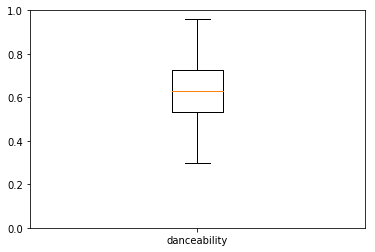

In [25]:
import matplotlib.pyplot as plt

labels = ['danceability']
fig, ax = plt.subplots()
ax.boxplot(df['danceability'])
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
plt.show()

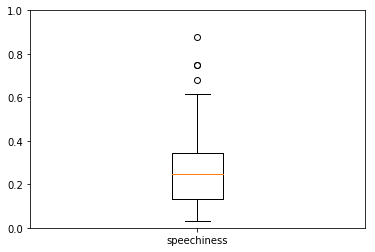

In [26]:
labels = ['speechiness']
fig, ax = plt.subplots()
ax.boxplot(audio_features_df['speechiness'])
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
plt.show()

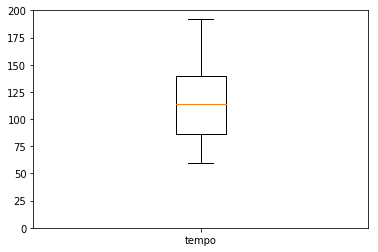

In [30]:
labels = ['tempo']
fig, ax = plt.subplots()
ax.boxplot(audio_features_df['tempo'])
ax.set_ylim(0,200)
ax.set_xticklabels(labels)
plt.show()